### Chapter 7.1
# Video Streaming QoS and QoE
---
>(c) Tobias Hossfeld  (Aug 2021)<br><br>
> This script and the figures are part of the following book. The book is to be cited whenever the script is used (copyright CC BY-SA 4.0):<br>
> *Tran-Gia, P. & Hossfeld, T. (2021). 
Performance Modeling and Analysis of Communication Networks - A Lecture Note.
Würzburg University Press.*
> *https://doi.org/10.25972/WUP-978-3-95826-153-2*

---

The video buffer of a video client is modeled as M/M/1 queue with a trigger mechanism called $N$-policy, which allows study of the stalling behavior of HTTP video streaming. 


The video contents are downloaded as HTTP segments which contain a certain video play time $B$. This video play time per HTTP segment is assumed to follow an exponential distribution with parameter $\mu=1/E[B]$.

Consider that the playback of a video consists of multiple HTTP segments.
The HTTP segments are downloaded in-order and arrive at the client with rate $\lambda$. Assuming the interarrival times of HTTP segments at the video buffer follow an exponential distribution with rate $\lambda$.

In order to reduce the number of stalling events during playback, the video player uses a playback buffer. Video playback stops, if the buffer empties and is only, but immediately resumed, if the video buffer grows and reaches the level containing $N$ HTTP segments again. In the queueing literature, this strategy is referred to as $N$-policy.

The utilization of the system equals the offered load according to the utilization law $\rho = \frac{\lambda}{\mu}$ which corresponds to the ratio of the time when the video player (server) is busy. Hence, if $\rho<1$, the server may get idle and stalling occurs.

The system characteristics can be derived by means of continuous-time Markov chains.

#### Stall ratio
The stall ratio $\psi$ is the fraction of time the video player is idle.

$ \displaystyle
\psi = 1 - \rho = 1 - \frac{\lambda}{\mu}
$

#### Average stall duration
The average stall duration $L$ is the average idle duration - which is independent of the video play time per HTTP segment $E[B]$.

$ \displaystyle
L = \frac{N}{\lambda}
$

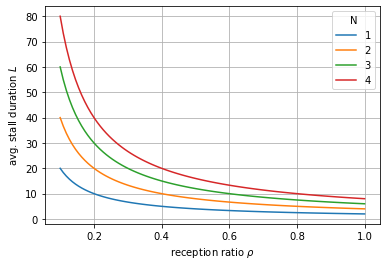

In [15]:
from matplotlib import pyplot as plt
import numpy as np

lam = 0.4 # arrival rate of HTTP segments [1/second]
mu = 0.5  # E[B]=1/mu is the mean video duration of an HTTP segment
N = 2  # parameter of the N-policy

# average stall duration [second]
def L(lam=lam, mu=mu, N=2):
    return N/lam

lams = np.linspace(0.05,mu,100)
for N in [1,2,3,4]:
    plt.plot(lams/mu, L(lams,mu,N), label=N)
plt.xlabel('reception ratio $\\rho$')    
plt.ylabel('avg. stall duration $L$')
plt.legend(title='N')
plt.grid(which='major');

#### Stall frequency
The stall frequency $F$ is the number of interruptions per video playout time. 

$ \displaystyle
F = \frac{\mu-\lambda}{N} 
$

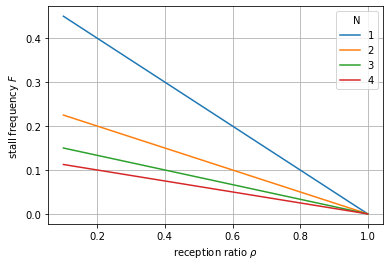

In [16]:
# stall frequency [stalls/second]
def F(lam=lam, mu=mu, N=2):
    return (mu-lam)/N

for N in [1,2,3,4]:
    plt.plot(lams/mu, F(lams,mu,N), label=N)
plt.xlabel('reception ratio $\\rho$')    
plt.ylabel('stall frequency $F$')
plt.legend(title='N')
plt.grid(which='major');

#### Quality of Experience
The QoE model takes into account the stall frequency $F$ and the average duration $L$ per stall based on subjective experiments. An exponential relationship according to the IQX hypothesis is observed. The parameter $\gamma$ reflects the minimum observed QoE value as measured in the subjective tests. 
Thereby, the video with the same stall characteristics is shown to several users who rate the QoE on a 5-point rating scale. For quantifying QoE, the mean opinion score (MOS) is used by averaging over the subjects. The QoE model found $\gamma=1.5$. In case no stalling occurs, the maximum QoE score of 5 is obtained, leading to the scale parameter $\alpha = 3.5$.

The crucial parameters of the IQX model are the sensitivity parameters $\beta_L$ and $\beta_F$ in the exponent which are weighting the influence of the average stall duration $L$ per interruption and the stall frequency $F$. 

$ \displaystyle
 f(L,F) = \alpha e^{-\beta_F\cdot F - \beta_L \cdot L} + \gamma 
$

Subjective tests revealed: $\beta_L = 0.15 s^{-1}, \beta_F = 0.19 \cdot 30 s$ with units $[L]=s, [F]=s^{-1}$.


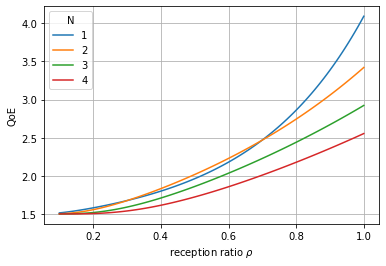

In [17]:
def qoe(lam=lam, mu=mu, N=N):
    alpha = 3.5
    beta_L = 0.15
    beta_F = 0.19*30
    gamma = 1.5
    return alpha*np.exp(-beta_F*F(lam,mu,N)-beta_L*L(lam,mu,N))+gamma

for N in [1,2,3,4]:
    plt.plot(lams/mu, qoe(lams,mu,N), label=N)
plt.xlabel('reception ratio $\\rho$')    
plt.ylabel('QoE')
plt.legend(title='N')
plt.grid(which='major');

For many situations, $N=1$ leads to the best QoE. 

#### QoE-optimal Threshold for N-Policy
The QoE-optimal threshold $N$ can be derived by considering the function 

$
g(N) = \alpha e^{-\beta_F\cdot \frac{\mu-\lambda}{N} - \beta_L \cdot \frac{N}{\lambda}} + \gamma 
$

This leads to the QoE-optimal value through differentation of $g(N)$.

$ N =  (\mu - \lambda)\cdot \lambda \cdot \frac{\beta_F}{\beta_L} $

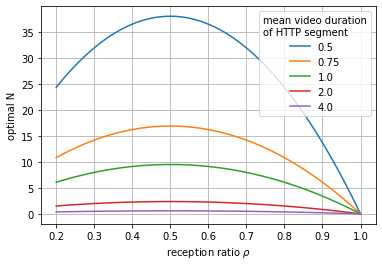

In [34]:
def optN(lam=lam, mu=mu):
    beta_L = 0.15
    beta_F = 0.19*30
    return (mu-lam)*lam*beta_F/beta_L

rhos = np.linspace(0.2,1,100)
for EB in [0.5, 0.75, 1.0, 2.0, 4.0]:
    mus = 1.0/EB
    lams = rhos*mus
    plt.plot(rhos, optN(lams,mus), label=EB)
plt.xlabel('reception ratio $\\rho$')    
plt.ylabel('optimal N')
plt.legend(title='mean video duration\nof HTTP segment')
plt.grid(which='major');

It should be noted that in practice $N$ needs to be an integer value and $N\geq1$.

The optimal threshold $N$ of segments means that the video time $D = N \cdot E[B]$ is on average available in the buffer when the playout starts again after a video interruption.
It can be seen that the curves are overlapping. Thus, the buffered video amount is the crucial component for the optimal playout. The $D$-policy is a different scheduling policy which works as follows. Again, the server (i.e. video player) is turned off at the end of a busy period and turned on when the cumulative amount of work (i.e. video play time) reaches the threshold $D$. Recent developments in Internet video delivery allow to start the playout, even if the entire segment is not completely downloaded, thus allowing an implementation of the $D$-policy.

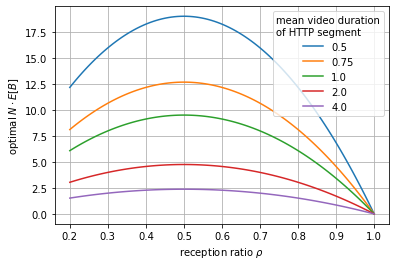

In [36]:
for EB in [0.5, 0.75, 1.0, 2.0, 4.0]:
    mus = 1.0/EB
    lams = rhos*mus
    plt.plot(rhos, optN(lams,mus)*EB, label=EB)
plt.xlabel('reception ratio $\\rho$')    
plt.ylabel('optimal $N\cdot E[B]$')
plt.legend(title='mean video duration\nof HTTP segment')
plt.grid(which='major');